### 07. Atmospheric correction using 6SV
#### Gayantha R. L. Kodikara 2023/09/21 @ UWM Update 29/02/2024, 31/05/2024

In [1]:
# Import libraries
import numpy as np
import exiftool
import pysolar.solar as pysolar
from datetime import datetime, timedelta
import pytz
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable
from osgeo import gdal

In [2]:
# Import the image
imageR1 = 'IMG_0177_1.tif'

In [3]:
# Get All the information from the Band
from exiftool import ExifToolHelper
with ExifToolHelper() as et:
    for d in et.get_metadata(imageR1):
        for k, v in d.items():
            print(f"Dict: {k} = {v}")

Dict: SourceFile = IMG_0177_1.tif
Dict: ExifTool:ExifToolVersion = 12.5
Dict: File:FileName = IMG_0177_1.tif
Dict: File:Directory = .
Dict: File:FileSize = 2465646
Dict: File:FileModifyDate = 2023:07:12 10:57:02-05:00
Dict: File:FileAccessDate = 2024:03:08 00:00:00-06:00
Dict: File:FileInodeChangeDate = 2024:05:31 14:54:26-05:00
Dict: File:FilePermissions = 100755
Dict: File:FileType = TIFF
Dict: File:FileTypeExtension = TIF
Dict: File:MIMEType = image/tiff
Dict: File:ExifByteOrder = II
Dict: EXIF:SubfileType = 0
Dict: EXIF:ImageWidth = 1280
Dict: EXIF:ImageHeight = 960
Dict: EXIF:BitsPerSample = 16
Dict: EXIF:Compression = 1
Dict: EXIF:PhotometricInterpretation = 1
Dict: EXIF:Make = MicaSense
Dict: EXIF:Model = RedEdge-M
Dict: EXIF:StripOffsets = (Binary data 70 bytes, use -b option to extract)
Dict: EXIF:Orientation = 1
Dict: EXIF:SamplesPerPixel = 1
Dict: EXIF:RowsPerStrip = 100
Dict: EXIF:StripByteCounts = (Binary data 69 bytes, use -b option to extract)
Dict: EXIF:PlanarConfigurat

In [4]:
# Get the utc time zone and date and time of the image capture.
from exiftool import ExifToolHelper
with ExifToolHelper() as et:
    time = et.get_tags([imageR1], tags=['EXIF:DateTimeOriginal','EXIF:SubSecTime'])

DateTime = time[0].get('EXIF:DateTimeOriginal')
SubTime = time[0].get('EXIF:SubSecTime')
utc_time = datetime.strptime(DateTime, "%Y:%m:%d %H:%M:%S")
# Find time zone
negative = 1.0
if SubTime < 0:
    negative = -1.0
    SubTime *= -1.0
SubTime = float('0.{}'.format(int(SubTime)))
SubTime *= negative
ms = SubTime * 1e3
utc_time += timedelta(milliseconds = ms)
timezone = pytz.timezone('UTC')
UTC_Time = timezone.localize(utc_time)
UTC_Time

datetime.datetime(2023, 7, 12, 9, 57, 3, 959758, tzinfo=<UTC>)

In [5]:
# Get the position of the image sensor
from exiftool import ExifToolHelper
with ExifToolHelper() as et:
    posi = et.get_tags([imageR1], tags=['EXIF:GPSLatitude','EXIF:GPSLatitudeRef', 'EXIF:GPSLongitude', 'EXIF:GPSLongitudeRef', 'EXIF:GPSAltitude'])

Lat = posi[0].get('EXIF:GPSLatitude')
LatRef = posi[0].get('EXIF:GPSLatitudeRef')
Lon = posi[0].get('EXIF:GPSLongitude')
LonRef = posi[0].get('EXIF:GPSLongitudeRef')
Alt = posi[0].get('EXIF:GPSAltitude')
if LatRef == 'S':
    Lat *= -1.0
if LonRef == 'W':
    Lon *= -1.0
print('Lat:',Lat, 'Lon:', Lon, 'Alt:', Alt)

Lat: -2.3094972 Lon: 35.927391 Alt: 719.87


In [6]:
# Calculate the sun altitude (elevation of the sun above the horizon), and sun azimuth (heading of the sun)
altitude = 0
azimuth = 0
sunAltitude = pysolar.get_altitude(Lat,Lon,UTC_Time)
sunAzimuth = pysolar.get_azimuth(Lat, Lon,UTC_Time)
sunZenith = 90 - sunAltitude
print('SunZenith:',sunZenith, 'SunAzimuth:',sunAzimuth)

SunZenith: 24.557814346727383 SunAzimuth: 351.5094193360959


In [7]:
# Since our drone takes pictures from its Nadir point (we assumed)
viewAzimuth = 0
viewZenith = 0

In [8]:
# The values calculated from the 6SV model
# y = x * (radiance) -b
# B1: x = 0.00199, b = 0.17479
# B2: x = 0.00219, b = 0.12874
# B3: x = 0.00251, b = 0.09461
# B4: x = 0.00391, b = 0.06806
# B5: x = 0.00301, b = 0.08498
Ref_6SV = np.array([[0.00199,0.17416],[0.00219,0.12837],[0.00251,0.09441],[0.00390,0.06797],[0.00300,0.08482]])
np.save('Pininj_0177_6SV_coeff.npy',Ref_6SV)
Ref_6SV

array([[0.00199, 0.17416],
       [0.00219, 0.12837],
       [0.00251, 0.09441],
       [0.0039 , 0.06797],
       [0.003  , 0.08482]])

In [9]:
Ref_6SV[1,0]

0.00219

In [10]:
# Load the image
Radiance = np.load('np3DRadiance.npy')
Radiance.shape

(900, 1200, 5)

In [11]:
# Create empty image
Reflectance = np.zeros((900,1200,5))
Reflectance.shape

(900, 1200, 5)

In [12]:
# Radiance to Reflectance = Panel Reflectance / Mean Radiance
Reflectance[:,:,0] = (Radiance[:,:,0] * Ref_6SV[0,0]) + Ref_6SV[0,1]
Reflectance[:,:,1] = (Radiance[:,:,1] * Ref_6SV[1,0]) + Ref_6SV[1,1]
Reflectance[:,:,2] = (Radiance[:,:,2] * Ref_6SV[2,0]) + Ref_6SV[2,1]
Reflectance[:,:,3] = (Radiance[:,:,3] * Ref_6SV[3,0]) + Ref_6SV[3,1]
Reflectance[:,:,4] = (Radiance[:,:,4] * Ref_6SV[4,0]) + Ref_6SV[4,1]
np.save('Pininj_0177_6sv_np3D.npy',Reflectance)

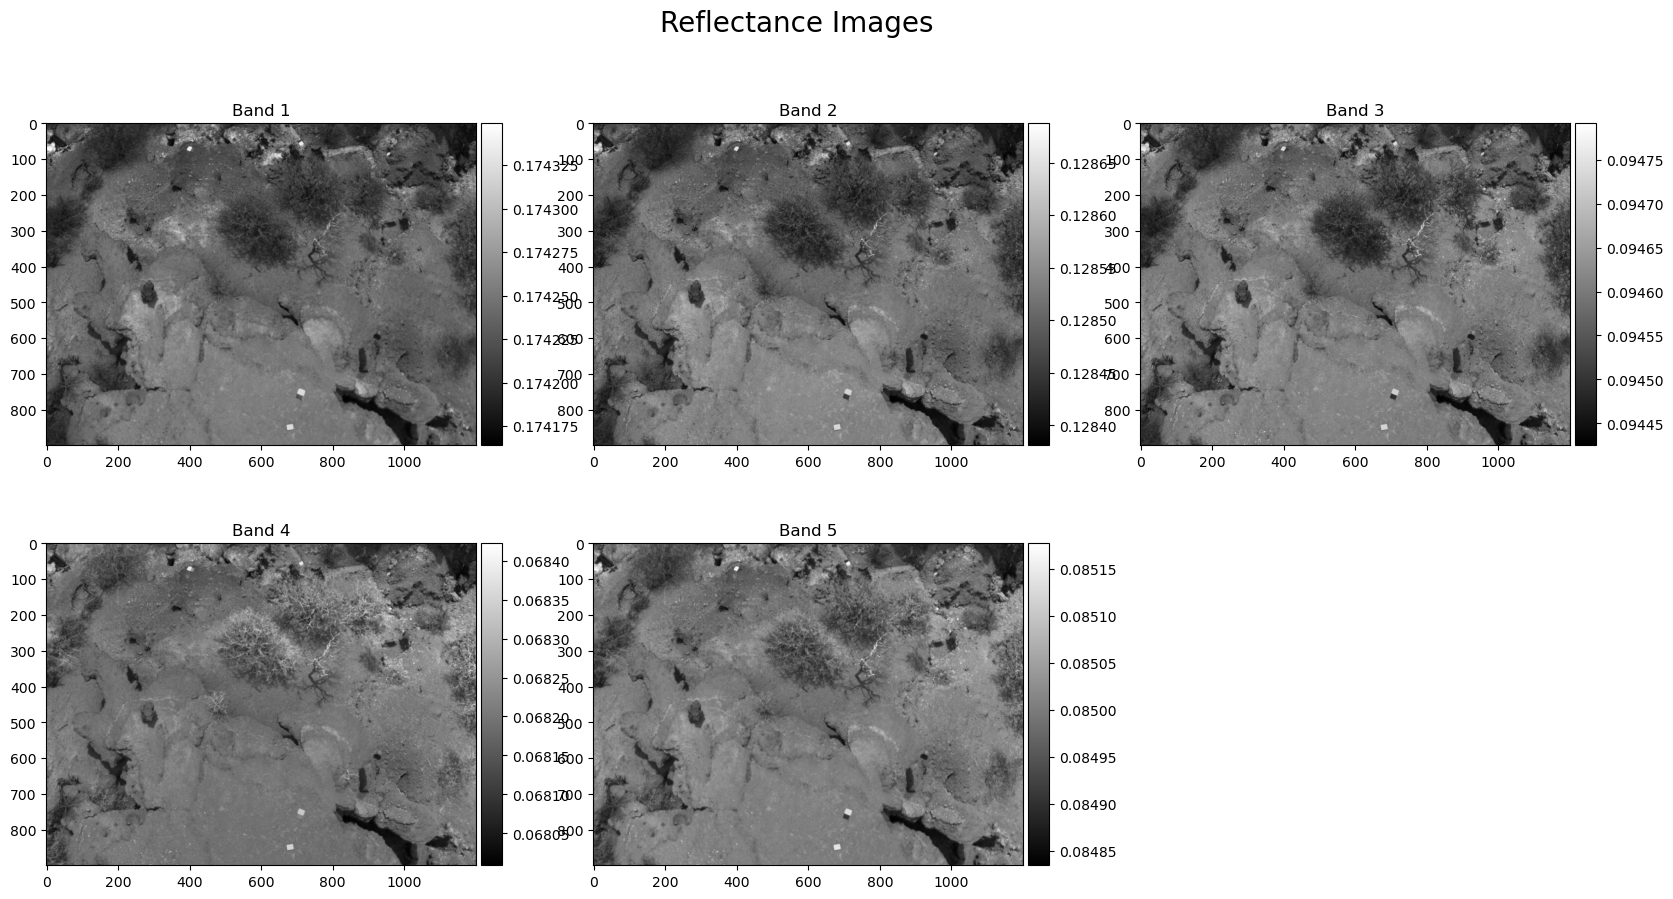

In [13]:
#fig, ((ax1, ax2), (ax3,ax4), (ax5, ax6)) = plt.subplots(ncols=2,nrows=3,figsize=(15, 15))
fig = plt.figure(figsize=(20, 10))
spec = mpl.gridspec.GridSpec(ncols=3, nrows=2)

ax1 = fig.add_subplot(spec[0,0])
ax2 = fig.add_subplot(spec[0,1])
ax3 = fig.add_subplot(spec[0,2])
ax4 = fig.add_subplot(spec[1,0])
ax5 = fig.add_subplot(spec[1,1])
im1 = ax1.imshow(Reflectance[:,:,0], cmap='gray')
im2 = ax2.imshow(Reflectance[:,:,1], cmap='gray')
im3 = ax3.imshow(Reflectance[:,:,2], cmap='gray')
im4 = ax4.imshow(Reflectance[:,:,3], cmap='gray')
im5 = ax5.imshow(Reflectance[:,:,4], cmap='gray')
ax1.set_title('Band 1')
ax2.set_title('Band 2')
ax3.set_title('Band 3')
ax4.set_title('Band 4')
ax5.set_title('Band 5')
div1 = make_axes_locatable(ax1)
cax1 = div1.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im1, cax=cax1)
div2 = make_axes_locatable(ax2)
cax2 = div2.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im2, cax=cax2)
div3 = make_axes_locatable(ax3)
cax3 = div3.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im3, cax=cax3)
div4 = make_axes_locatable(ax4)
cax4 = div4.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im4, cax=cax4)
div5 = make_axes_locatable(ax5)
cax5 = div5.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im5, cax=cax5)
fig.suptitle('Reflectance Images', fontsize=20)
plt.show()

In [14]:
def array2geotif(array, out_path):  
    nrows, ncols, nbands = array.shape
    driver = gdal.GetDriverByName('GTiff')
    dataset = driver.Create(out_path, ncols, nrows, nbands, gdal.GDT_Float32)
    for i in range(nbands):
        dataset.GetRasterBand(i+1).WriteArray(array[:,:,i])
    #dataset.SetGeoTransform(gt)
    #dataset.SetProjection(prj)
    dataset.FlushCache()
    dataset = None

In [15]:
array2geotif(Reflectance, 'Pininj_0177_6sv_Ref.tif')

/home/kodi/.local/lib/python3.9/site-packages/osgeo/gdal.py:312: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


#### what will do next? ;-) 